Based on https://github.com/MachineLearnia/Deep-Learning-Youtube

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

# Fonctions

In [2]:
def initialisation(dimensions):
    
    parametres = {}
    C = len(dimensions)

    np.random.seed(1)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [3]:
def forward_propagation(X, parametres):
  
    activations = {'A0': X}

    C = len(parametres) // 2

    for c in range(1, C + 1):

        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

    return activations

In [4]:
def back_propagation(y, parametres, activations):

    m = y.shape[1]
    C = len(parametres) // 2

    dZ = activations['A' + str(C)] - y
    gradients = {}

    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
    if c > 1:
        dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

    return gradients

In [5]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [6]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [7]:
def deep_neural_network(X_train, y_train, X_test, y_test, hidden_layers = (16, 16, 16), learning_rate = 0.001, n_iter = 3_000):
    
    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X_train.shape[0])
    dimensions.append(y_train.shape[0])
    np.random.seed(1)
    parametres = initialisation(dimensions)
    parametres_init = parametres.copy()
    
    # tableau numpy contenant les futures accuracy et log_loss
    training_history = np.zeros((int(n_iter), 4))
    
    param_history = np.zeros((int(n_iter), 1), dtype=dict)
    
    C = len(parametres) // 2

    # gradient descent
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X_train, parametres)
        gradients = back_propagation(y_train, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]
        
        # calcul du log_loss et de l'accuracy pour train
        training_history[i, 0] = (log_loss(y_train.flatten(), Af.flatten()))
        y_pred = predict(X_train, parametres)
        training_history[i, 2] = (accuracy_score(y_train.flatten(), y_pred.flatten()))
        
        # calcul du log_loss et de l'accuracy pour test
        A_test  = forward_propagation(X_test, parametres)["A"+str(C)]
        training_history[i, 1] = (log_loss(y_test.flatten(), A_test.flatten()))
        y_pred_test = predict(X_test, parametres)
        training_history[i,3] = (accuracy_score(y_test.flatten(), y_pred_test.flatten()))
        
        param_history[i,0] = parametres
    
    # Plot courbe d'apprentissage, et frontière de décision
    
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.plot(training_history[:, 1], label='test loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(training_history[:, 2], label='train acc')
    plt.plot(training_history[:, 3], label='test acc')
    plt.legend()
    
    X = np.concatenate((X_train, X_test),axis=1)
    y = np.concatenate((y_train, y_test),axis=1)
    x1_len = 200
    x2_len = 200
    x1, x2 = np.meshgrid(np.linspace(min(X[0,:]), max(X[0,:]), x1_len),
                        np.linspace(min(X[1,:]), max(X[1,:]), x2_len))
    Z = predict(np.c_[x1.flatten(), x2.flatten()].T, parametres)
    Z = Z.reshape(x1.shape)
    Z_init = predict(np.c_[x1.flatten(), x2.flatten()].T, parametres_init)
    Z_init = Z_init.reshape(x1.shape)
    
    plt.subplot(1, 3, 3)
    plt.contour(x1, x2, Z, [0.5], colors='red', linewidths = 1)
    #plt.contour(x1, x2, Z_init, [0.5], colors='blue', linewidths = 1)
    plt.contourf(x1, x2, Z, 1, alpha=0.5)
    plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
    plt.show()

    return training_history, param_history

# Dataset

dimensions de X_train: (2, 160)
dimensions de y_train: (1, 160)
dimensions de X_test: (2, 40)
dimensions de y_test: (1, 40)


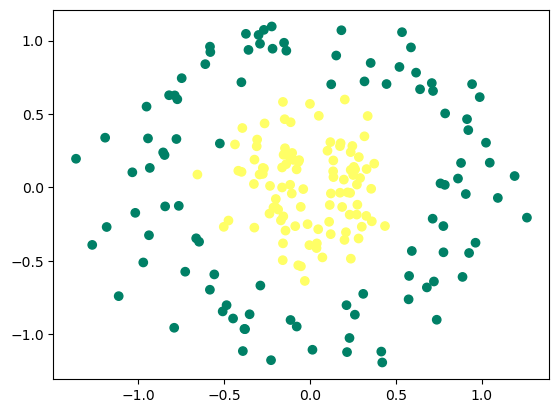

In [8]:
N_sample = 200

X, y = make_circles(n_samples=N_sample, noise=0.15, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))
sep = int(0.8*N_sample) # indices de separation des data train/test
X_train = X[:, :sep]
y_train = y[:, :sep]
X_test = X[:, sep:]
y_test = y[:, sep:]

print('dimensions de X_train:', X_train.shape)
print('dimensions de y_train:', y_train.shape)
print('dimensions de X_test:', X_test.shape)
print('dimensions de y_test:', y_test.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

100%|████████████████████████████████████████████| 5000/5000 [00:20<00:00, 239.16it/s]


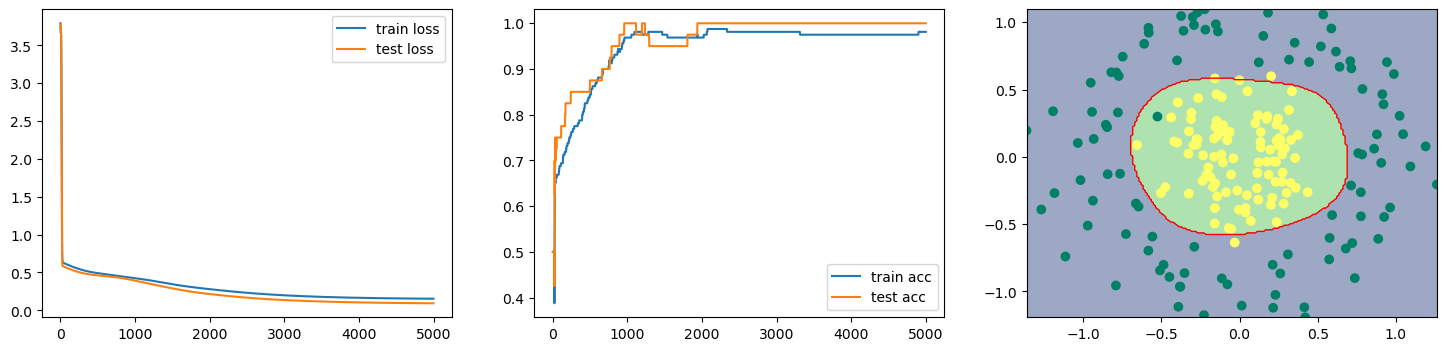

In [9]:
training_history, param_history = deep_neural_network(X_train, y_train, X_test, y_test, hidden_layers = (100, 100, 100), learning_rate = 0.01, n_iter = 5_000)

## Animation

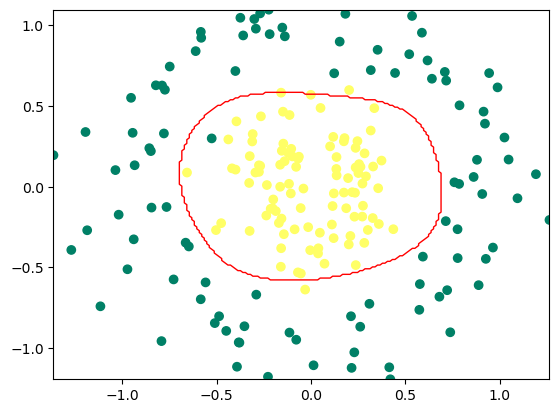

In [14]:
from matplotlib.animation import FuncAnimation
import sys

fig, ax = plt.subplots()
X = np.concatenate((X_train, X_test),axis=1)
y = np.concatenate((y_train, y_test),axis=1)
x1_len = 200
x2_len = 200
x1, x2 = np.meshgrid(np.linspace(min(X[0,:]), max(X[0,:]), x1_len),
                    np.linspace(min(X[1,:]), max(X[1,:]), x2_len))

ln, = ax.plot([], [], 'ro')

def init():
    return ln,

def animate(frame):
    z = predict(np.c_[x1.flatten(), x2.flatten()].T, param_history[frame,0])
    z = z.reshape(x1.shape)
    ax.clear()
    ax.contour(x1, x2, z, [0.5], colors='red', linewidths = 1)
    ax.scatter(X[0, :], X[1, :], c=y, cmap='summer')

ani = FuncAnimation(fig, animate, np.arange(5000), interval=20, blit=False)

In [15]:
ani.save("anim.wav")

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .wav

In [ ]:
from IPython.display import Video

Video("anim.wav", embed=True)